<a href="https://colab.research.google.com/github/LoniQin/deep_learning_notebooks/blob/master/tensorflow/Stock_Price_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")
from pandas_datareader.data import DataReader
from datetime import datetime

## Load data

In [16]:
company = 'AAPL'
company_name = 'APPLE'
end = datetime.now()
start = datetime(2012, end.month, end.day)
stock_data = DataReader(company, 'yahoo', start, end)

In [17]:
stock_data.tail(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-03-12,121.169998,119.160004,120.400002,121.029999,87963400.0,121.029999
2021-03-15,124.000000,120.419998,121.410004,123.989998,92403800.0,123.989998
2021-03-16,127.220001,124.720001,125.699997,125.570000,114740000.0,125.570000
2021-03-17,125.860001,122.339996,124.050003,124.760002,111437500.0,124.760002
2021-03-18,123.180000,120.320000,122.879997,120.529999,121229700.0,120.529999
2021-03-19,121.430000,119.680000,119.900002,119.989998,185023200.0,119.989998
2021-03-22,123.870003,120.260002,120.330002,123.389999,111912300.0,123.389999
2021-03-23,124.239998,122.139999,123.330002,122.540001,95467100.0,122.540001
2021-03-24,122.900002,120.070000,122.820000,120.089996,88322700.0,120.089996


In [18]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2265 entries, 2012-03-26 to 2021-03-25
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       2265 non-null   float64
 1   Low        2265 non-null   float64
 2   Open       2265 non-null   float64
 3   Close      2265 non-null   float64
 4   Volume     2265 non-null   float64
 5   Adj Close  2265 non-null   float64
dtypes: float64(6)
memory usage: 123.9 KB


Text(0.5, 1.0, 'APPLE')

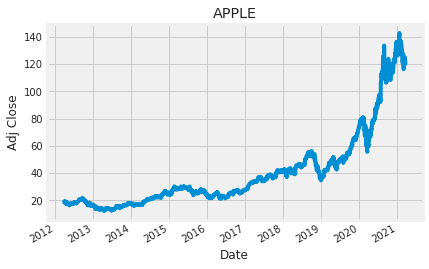

In [19]:
stock_data["Adj Close"].plot()
plt.ylabel("Adj Close")
plt.title(company_name)

## Calculate moving average of the stock

In [20]:
for ma in [10, 20, 50]:
  stock_data[f"MA for {ma} days"] = stock_data['Adj Close'].rolling(ma).mean()

In [21]:
stock_data.columns

Index(['High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'MA for 10 days',
       'MA for 20 days', 'MA for 50 days'],
      dtype='object')

## Show histogram

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fed6d89a390>,
      dtype=object)

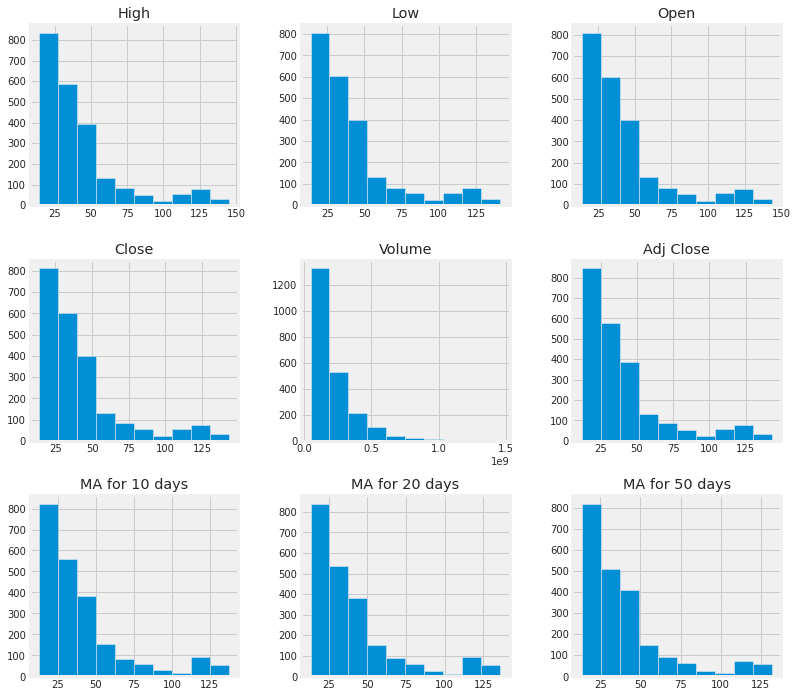

In [22]:
stock_data.hist(figsize=(12, 12))

## 

Text(0.5, 1.0, 'APPLE')

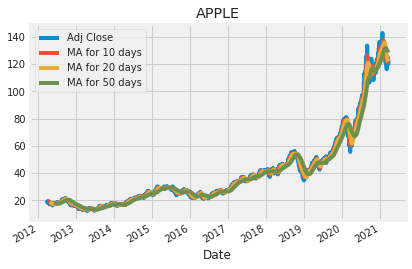

In [23]:
stock_data[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot()
plt.title(company_name)

## Calcuate daily return

In [24]:
stock_data["Daily Return"] = stock_data["Adj Close"].pct_change()

Text(0.5, 1.0, 'APPLE')

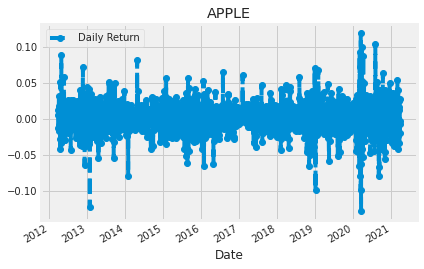

In [25]:
stock_data["Daily Return"].plot(legend=True, linestyle='--', marker='o')
plt.title(company_name)

In [27]:
# Create a new dataframe with only the 'Close column 
data = stock_data.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .95 ))

training_data_len

2152

In [28]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.05982669],
       [0.0618997 ],
       [0.06276759],
       ...,
       [0.8404179 ],
       [0.82145685],
       [0.81870947]])

In [29]:
train_data = scaled_data[0:int(training_data_len), :]
x_train = []
y_train = []
for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])
x_train, y_train = np.array(x_train), np.array(y_train)

In [30]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [31]:
x_train.shape

(2092, 60, 1)

## Build the model

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential([
  LSTM(128, return_sequences=True, input_shape = (x_train.shape[1], 1)),
  LSTM(64, return_sequences=False),
  Dense(25),
  Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 60, 128)           66560     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1625      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 26        
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [34]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

2092/2092 [==============================] - 63s 29ms/step - loss: 0.0033


## Predict data

In [36]:
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])
x_test = np.array(x_test)
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
rmse

5.546723019033728

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


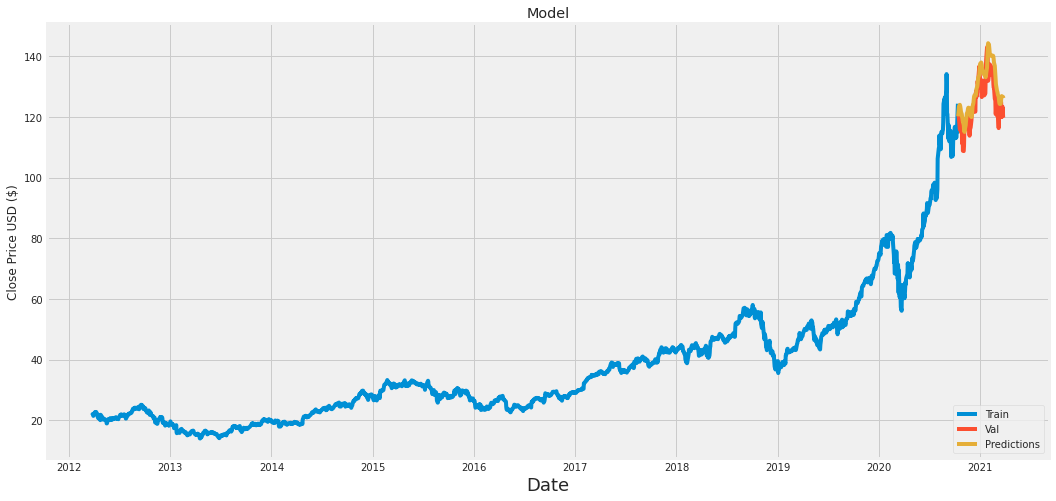

In [38]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(16, 8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()